In [4]:
import pandas as pd
import numpy as np
import math
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt

In [5]:
# Создадим таблицу с данными

moms_height = np.array([162, 175, 163, 170, 175])
dads_height = np.array([173, 170, 175, 180, 185])
child_height = np.array([168, 172, 168, 181, 180])

df = pd.DataFrame(zip(moms_height, dads_height, child_height), 
                  columns=['Moms_height', 'Dads_height', 'Child_height'], 
                  index=['Семья 1', 'Семья 2', 'Семья 3', 'Семья 4', 'Семья 5'])
print(df)

         Moms_height  Dads_height  Child_height
Семья 1          162          173           168
Семья 2          175          170           172
Семья 3          163          175           168
Семья 4          170          180           181
Семья 5          175          185           180



--- Результаты простой линейной регрессии ---
                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     3.551
Date:                Tue, 25 Nov 2025   Prob (F-statistic):              0.156
Time:                        12:55:06   Log-Likelihood:                 14.297
No. Observations:                   5   AIC:                            -24.59
Df Residuals:                       3   BIC:                            -25.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

C:\Users\Unaagy\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


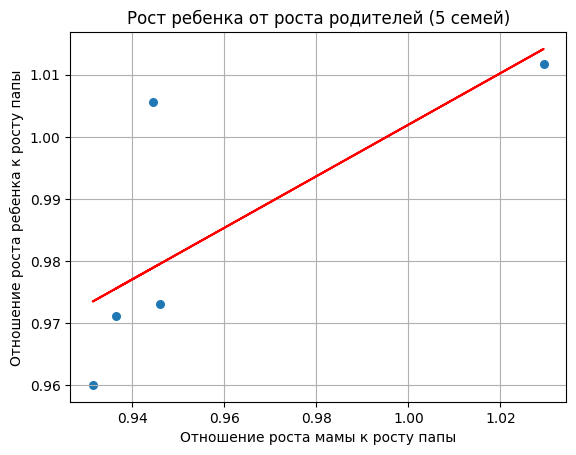

In [6]:
# Посмотреть в относительных величинах
# Ввести коэффициент между ростом папы и мамы.
x_parents = df['Moms_height'] / df['Dads_height']
y_child = df['Child_height'] / df['Dads_height']

# Создадим датасет с новыми данными
for i in x_parents, y_child:
    regres_df = pd.DataFrame(zip(x_parents, y_child), 
                  columns=['x_parents', 'y_child'], 
                  index=['Семья 1', 'Семья 2', 'Семья 3', 'Семья 4', 'Семья 5'])
    
# OLS - простая линейная регрессия
model = smf.ols(formula="y_child ~ x_parents", data=regres_df).fit()

print("\n--- Результаты простой линейной регрессии ---")
print(model.summary())

# Построим график зависимости роста ребенка от роста мамы и папы
point_size = 30
plt.scatter(x_parents, y_child, s=point_size)
# Добавляем линию регрессии
plt.plot(regres_df['x_parents'], model.fittedvalues, color='red', label=f'Линия регрессии (R²={model.rsquared:.2f})')

plt.xlabel('Отношение роста мамы к росту папы')
plt.ylabel('Отношение роста ребенка к росту папы')
plt.title('Рост ребенка от роста родителей (5 семей)')
plt.grid(True)

plt.show()

In [7]:
# Проверим корреляцию наших отношений

print('Pearson correlation: ')
print(pearsonr(regres_df['x_parents'], 
               regres_df['y_child']))

Pearson correlation: 
PearsonRResult(statistic=np.float64(0.7362338064012476), pvalue=np.float64(0.15602198953617544))


In [8]:
# Нам надо разделить данные на зависимые и независимые переменные. Или на фичи (факторы) и отклик

X_sk = regres_df.iloc[:,0:1].values
y_sk = regres_df.iloc[:,1].values

print(X_sk.shape)
print(y_sk.shape)

(5, 1)
(5,)


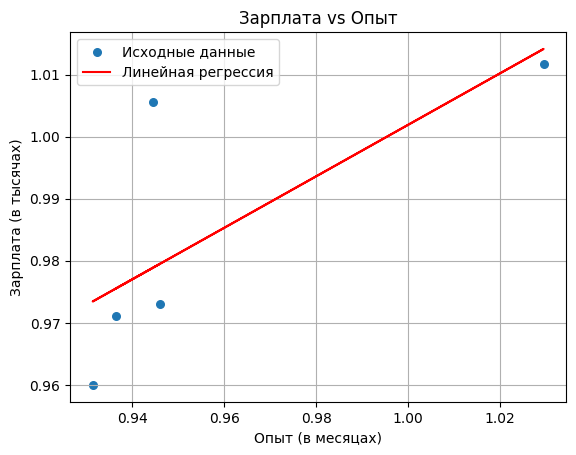

Linear Regression: y = 0.42 * x + 0.59


In [9]:
# Построим линейную регрессию
lin_reg = LinearRegression()

# Обучим алгоритм на наших данных
lin_reg.fit(X_sk, y_sk)
y_pred_lin_sk = lin_reg.predict(X_sk)

# Построим график данных и линейной регрессии
plt.scatter(x_parents, y_child, label='Исходные данные', s=point_size)
plt.plot(X_sk, y_pred_lin_sk, color='r', label='Линейная регрессия')
plt.xlabel('Опыт (в месяцах)')
plt.ylabel('Зарплата (в тысячах)')
plt.title('Зарплата vs Опыт')
plt.grid(True)
plt.legend()
plt.show()


# Выведем коэффициенты уравнения линейной регрессии
a_sk = lin_reg.coef_[0]
b_sk = lin_reg.intercept_
print(f'Linear Regression: y = {a_sk:.2f} * x + {b_sk:.2f}')

In [10]:
# Посчитаем ошибки

# Вычисляем MSE (среднеквадратичная ошибка)
lin_mse = mean_squared_error(y_sk, y_pred_lin_sk)

# Вычислим RMSE (среднеквадратичная ошибка)
lin_rmse = math.sqrt(lin_mse)

# Вычислим MAE (средняя абсолютная ошибка)
lin_mae = mean_absolute_error(y_sk, y_pred_lin_sk)

# Выведем результаты
print(f'Linear Regression MSE: {lin_mse:.2f}')
print(f'Linear Regression RMSE: {lin_rmse:.2f}')
print(f'Linear Regression MAE: {lin_mae:.2f}')

Linear Regression MSE: 0.00
Linear Regression RMSE: 0.01
Linear Regression MAE: 0.01



--- Результаты Huber Regressor ---
Huber Regression MSE: 0.0002
Huber Regression RMSE: 0.0148
Huber Regression MAE: 0.0085


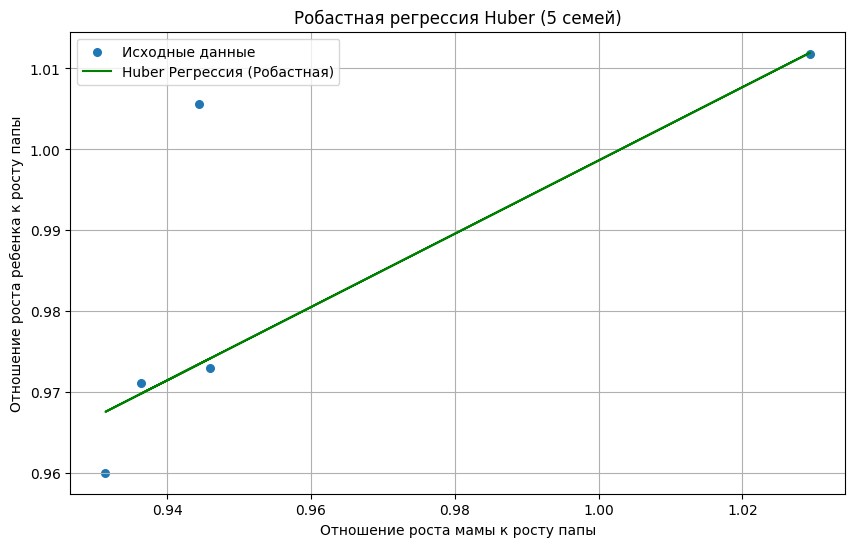

Huber Regressor (Scaled): y = 0.8034 * x + -0.2400


In [11]:
# 1. Подготовка данных для Sklearn
# X_sk (независимая переменная) и y_sk (зависимая переменная)
X_sk = regres_df.iloc[:, 0:1].values
y_sk = regres_df.iloc[:, 1].values

# 2. Масштабирование данных
# HuberRegressor, как и SVR, выигрывает от масштабирования данных.
# Это обязательный шаг, чтобы убедиться, что алгоритм сходится.

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_sk)
y_scaled = scaler_y.fit_transform(y_sk.reshape(-1, 1)).flatten()

# 3. Создание и обучение модели HuberRegressor
# epsilon=1.35 - стандартное значение, определяющее, когда ошибка считается выбросом.
huber_reg = HuberRegressor(epsilon=1.35, max_iter=1000)
huber_reg.fit(X_scaled, y_scaled)

# 4. Предсказание и обратное масштабирование
# Предсказываем масштабированные значения
y_pred_huber_scaled = huber_reg.predict(X_scaled)

# Обратное масштабирование для получения реальных значений
y_pred_huber = scaler_y.inverse_transform(y_pred_huber_scaled.reshape(-1, 1)).flatten()

# 5. Оценка ошибок
huber_mse = mean_squared_error(y_sk, y_pred_huber)
huber_rmse = math.sqrt(huber_mse)
huber_mae = mean_absolute_error(y_sk, y_pred_huber)

print("\n--- Результаты Huber Regressor ---")
print(f'Huber Regression MSE: {huber_mse:.4f}')
print(f'Huber Regression RMSE: {huber_rmse:.4f}')
print(f'Huber Regression MAE: {huber_mae:.4f}')

# 6. Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(X_sk, y_sk, label='Исходные данные', s=30)
plt.plot(X_sk, y_pred_huber, color='green', label='Huber Регрессия (Робастная)')

plt.xlabel('Отношение роста мамы к росту папы')
plt.ylabel('Отношение роста ребенка к росту папы')
plt.title('Робастная регрессия Huber (5 семей)')
plt.grid(True)
plt.legend()
plt.show()

# Выведем коэффициенты робастного уравнения
a_huber = huber_reg.coef_[0]
b_huber = huber_reg.intercept_

# Примечание: Коэффициенты (a_huber и b_huber) здесь находятся в МАСШТАБИРОВАННОМ пространстве.
# Для получения коэффициентов в исходном пространстве требуются дополнительные преобразования.
print(f'Huber Regressor (Scaled): y = {a_huber:.4f} * x + {b_huber:.4f}')

In [12]:
# Предположим, что нам нужно узнать рост детей, у которых родители имеют следующие данные:

In [13]:
# Новые данные
new_moms_height = np.array([170, 178])
new_dads_height = np.array([181, 185])

# Рассчитываем входную переменную (x_parents) для новых данных
x_parents_new = new_moms_height / new_dads_height

# Преобразуем его в формат, ожидаемый Sklearn (массив столбцов)
X_new = x_parents_new.reshape(-1, 1)

print("--- Новые данные для прогноза ---")
#print(f"Рост Мамы и Папы): {new_moms_height[i], new_dads_height[i]}")
print(f"Новое отношение (Мама/Папа): {X_new.flatten()}")

# Масштабирование новых входных данных
# Используем метод .transform(), а не .fit_transform(), чтобы применять правила, выученные на старых данных.
X_new_scaled = scaler_X.transform(X_new)

# Предсказание масштабированных значений
y_pred_huber_scaled_new = huber_reg.predict(X_new_scaled)

# Обратное масштабирование предсказанных значений (получаем реальное отношение y_child)
y_pred_huber_new = scaler_y.inverse_transform(y_pred_huber_scaled_new.reshape(-1, 1)).flatten()

print("\n--- Результаты прогнозирования ---")
for i, pred_ratio in enumerate(y_pred_huber_new):
    dads_h = new_dads_height[i]
    # Прогнозируемое абсолютное значение роста ребенка
    predicted_child_h = pred_ratio * dads_h
    
    print(f"Семья {chr(65 + i)}:")
    print(f"  Прогноз (отношение Ребенок/Папа): {pred_ratio:.4f}")
    print(f"  Прогноз роста ребенка (см): {predicted_child_h:.2f} см")

--- Новые данные для прогноза ---
Новое отношение (Мама/Папа): [0.93922652 0.96216216]

--- Результаты прогнозирования ---
Семья A:
  Прогноз (отношение Ребенок/Папа): 0.9711
  Прогноз роста ребенка (см): 175.76 см
Семья B:
  Прогноз (отношение Ребенок/Папа): 0.9815
  Прогноз роста ребенка (см): 181.57 см


In [14]:
# Формула МЛР: Child_height ~ Moms_height + Dads_height
# Y (зависимая) = Child_height
# X1 и X2 (независимые) = Moms_height и Dads_height
model_mlr = smf.ols(formula="Child_height ~ Moms_height + Dads_height", 
                    data=df).fit()

print("--- Результаты Множественной Линейной Регрессии (OLS) ---")
print(model_mlr.summary())

--- Результаты Множественной Линейной Регрессии (OLS) ---
                            OLS Regression Results                            
Dep. Variable:           Child_height   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     4.634
Date:                Tue, 25 Nov 2025   Prob (F-statistic):              0.177
Time:                        12:55:26   Log-Likelihood:                -11.449
No. Observations:                   5   AIC:                             28.90
Df Residuals:                       2   BIC:                             27.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

C:\Users\Unaagy\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [32]:
# Создание нового DataFrame с данными для прогноза
predict_df = pd.DataFrame({
    'Moms_height': [170, 178],
    'Dads_height': [181, 185]
})

# Прогнозирование с помощью обученной модели
# Метод .predict() принимает DataFrame, имена столбцов которого должны совпадать с именами предикторов в формуле.
y_pred_new = model_mlr.predict(predict_df)

print("\n--- Прогноз Роста Ребенка по МЛР ---")

for i in range(len(predict_df)):
    # Получаем входные данные из строки DataFrame
    mom_h = predict_df.iloc[i]['Moms_height']
    dad_h = predict_df.iloc[i]['Dads_height']
    
    # Получаем прогнозируемый рост ребенка
    child_h_pred = y_pred_new.iloc[i]
    
    # Вывод
    print(f"Семья {chr(65 + i)}:")
    print(f"Рост мамы: {mom_h:1.0f} см | Рост папы: {dad_h:1.0f} см | Прогнозируемый рост ребенка: {child_h_pred:1.2f} см")



--- Прогноз Роста Ребенка по МЛР ---
Семья A:
Рост мамы: 170 см | Рост папы: 181 см | Прогнозируемый рост ребенка: 177.24 см
Семья B:
Рост мамы: 178 см | Рост папы: 185 см | Прогнозируемый рост ребенка: 183.78 см
